In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from joblib import dump, load
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

from statsmodels.tsa.statespace.sarimax import SARIMAX


In [4]:
us = pd.read_csv(r'C:\Users\gurma\Downloads\archive\us_national_market_tracker.tsv000', delimiter='\t')
county = pd.read_csv(r'C:\Users\gurma\Downloads\archive\county_market_tracker.tsv000', delimiter='\t')
state = pd.read_csv(r'C:\Users\gurma\Downloads\archive\state_market_tracker.tsv000', delimiter='\t')

us.fillna(0, inplace=True)
county.fillna(0, inplace=True)
state.fillna(0, inplace=True)

data = us


In [5]:
# Select features and target
features = data[['median_sale_price', 'median_list_price', 'median_ppsf']]
target = data['median_sale_price_yoy']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize the base model
model = GradientBoostingRegressor(random_state=42)

"""
# Define the parameter distribution
param_dist = {
    'n_estimators': stats.randint(100, 300),
    'learning_rate': stats.uniform(0.01, 0.2),
    'max_depth': stats.randint(3, 6)
}
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=3, scoring='neg_mean_squared_error', verbose=2, random_state=42)
random_search.fit(X_train, y_train)"""

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   0.2s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=300; total time=   0.3s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=300; total time=   0.3s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=300; total time=   0.3s
[CV] END ..learning_rate=0.05, max_depth=4, n_estimators=100; total time=   0.0s
[CV] END ..learning_rate=0.05, max_depth=4, n_estimators=100; total time=   0.0s
[CV] END ..learning_rate=0.05, max_depth=4, n_es

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error', verbose=2)

In [6]:
"""predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print('Mean Squared Error:', mse)"""
dump(grid_search.best_estimator_, 'optimized_housing_model.pkl')


['optimized_housing_model.pkl']

In [7]:
model = load('optimized_housing_model.pkl')
#set to model
state_features = state[['median_sale_price', 'median_list_price', 'median_ppsf']]
features = state_features
# Make predictions

predictions = model.predict(features)
filtered_predictions = np.array(predictions)
filtered_predictions = filtered_predictions[filtered_predictions <= 0.4]

#visualization
predictions_df = pd.DataFrame(filtered_predictions, columns=['Predicted Values'])

#import actual data to compare
state_actual = state['median_sale_price_yoy']

predictions_df['Actual Values'] = state_actual.values


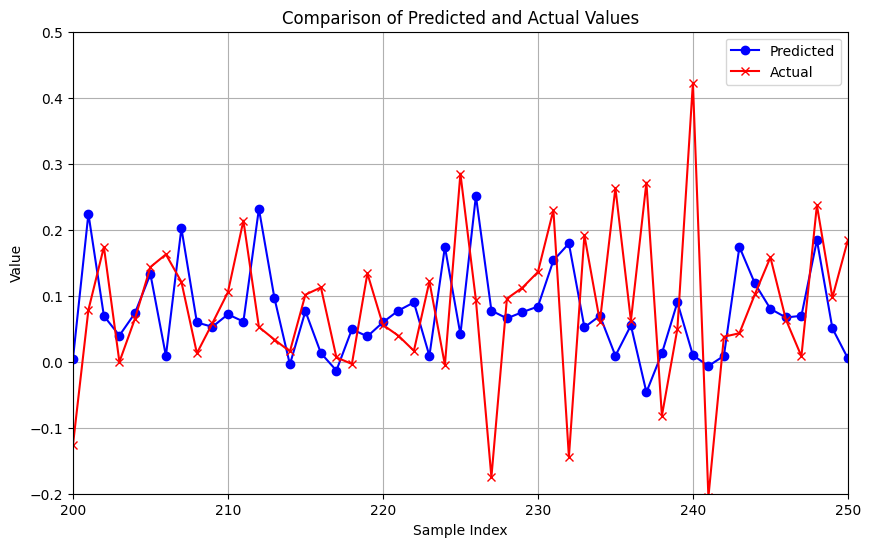

In [8]:

plt.figure(figsize=(10, 6))
plt.plot(predictions_df['Predicted Values'], label='Predicted', marker='o', color='b')
plt.plot(predictions_df['Actual Values'], label='Actual', marker='x', color='r')
plt.title('Comparison of Predicted and Actual Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
#zoom
plt.ylim([-0.2, 0.5])
plt.xlim(200, 250)
plt.legend()
plt.grid(True)
plt.show()



In [9]:
data=us
data['year'] = pd.to_datetime(data['period_begin']).dt.year

# Group by the year and aggregate the median sale price
# You can also aggregate other columns as needed
yearly_data = data.groupby('year').agg({
    'median_sale_price': 'mean',  # Calculate the average median sale price per year
    'homes_sold': 'sum',          # Sum homes sold to see the total volume per year
    'median_list_price': 'mean'   # Average list price per year
})

# Reset index if you want 'year' as a column
yearly_data.reset_index(inplace=True)

# Save or view the aggregated data
yearly_data.to_csv('yearly_aggregated_data.csv', index=False)
print(yearly_data)

median_sale_prices = data['median_sale_price']


model = SARIMAX(median_sale_prices, 
                order=(1, 1, 1), 
                seasonal_order=(1, 1, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()


   year  median_sale_price    homes_sold  median_list_price
0  2012      158585.859115  1.970699e+07      183806.560621
1  2013      178555.443136  2.166027e+07      206354.987207
2  2014      191370.263595  2.157794e+07      222493.682031
3  2015      203992.786112  2.375983e+07      236953.126911
4  2016      217905.243145  2.511763e+07      254232.142827
5  2017      233066.294934  2.588056e+07      270222.519941
6  2018      245298.851758  2.568782e+07      285676.763406
7  2019      255675.238191  2.591652e+07      296007.263983
8  2020      275264.791340  2.735192e+07      321451.466161
9  2021      320577.284467  2.932197e+07      358916.512800


In [10]:
data=us
data['year'] = pd.to_datetime(data['period_begin']).dt.year
data['date'] = pd.to_datetime(data['year'], format='%Y')  # Create a proper DateTime column
data.set_index('date', inplace=True)  # Set this DateTime as the index

median_sale_prices = data['median_sale_price'].resample('AS').mean()  # Resample annually and take the mean

# Fit the SARIMA model
model = SARIMAX(median_sale_prices,
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit()

# Forecast the next 5 years
forecast = results.get_forecast(steps=5)
predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Print the forecasted values and their confidence intervals
forecast_years = pd.date_range(start=median_sale_prices.index[-1] + pd.DateOffset(years=1), periods=5, freq='AS')
print("Forecasted Median Sale Prices:")
for date, mean, lower_ci, upper_ci in zip(forecast_years, predicted_mean, conf_int.iloc[:, 0], conf_int.iloc[:, 1]):
    print(f"Year {date.year}: ${mean:.2f} (95% CI: ${lower_ci:.2f} to ${upper_ci:.2f})")


Forecasted Median Sale Prices:
Year 2022: $320577.28 (95% CI: $317805.48 to $323349.09)
Year 2023: $320577.28 (95% CI: $316657.36 to $324497.21)
Year 2024: $426301.19 (95% CI: $421635.54 to $430966.84)
Year 2025: $446270.77 (95% CI: $441210.17 to $451331.38)
Year 2026: $459085.60 (95% CI: $454024.99 to $464146.20)


C:\Users\gurma\AppData\Local\Temp\ipykernel_11252\3460894636.py:6: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  median_sale_prices = data['median_sale_price'].resample('AS').mean()  # Resample annually and take the mean
c:\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\gurma\AppData\Local\Temp\ipykernel_11252\3460894636.py:22: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS'